In [1]:
!which python

/projappl/project_2013104/pengyan1/venv/bin/python


In [1]:
# Add package path to CSC os
import sys
import os

folder_path = os.path.abspath("/projappl/project_2013104/pengyan1/venv/lib/python3.10/site-packages")
if folder_path not in sys.path:
    sys.path.append(folder_path)

sys.path

['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\python312.zip',
 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\DLLs',
 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\\Lib',
 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0',
 '',
 'C:\\Users\\yanpe\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages',
 'C:\\Users\\yanpe\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32',
 'C:\\Users\\yanpe\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib',
 'C:\\Users\\yanpe\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Pyth

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchmetrics import JaccardIndex
import torch_geometric.transforms as T
from torch_geometric.datasets import S3DIS
from torch_geometric.loader import DataLoader
from torch_geometric.typing import WITH_TORCH_CLUSTER
from pyg_pointnet2 import PyGPointNet2

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")

In [2]:
print(torch.cuda.is_available())

True


In [3]:
test_area = 6  
#path = "/scratch/project_2013104/datasets/s3dis/" # CSC
path = r"C:\Users\yanpe\OneDrive - Metropolia Ammattikorkeakoulu Oy\Research\AI\scripts\datasets\s3dis" # Local

# transform and pre_transform
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
#pre_transform = T.NormalizeScale()

In [4]:
train_dataset = S3DIS(root=path, test_area=test_area, train=True, force_reload=True, 
                      transform=transform)#,pre_transform=pre_transform)
test_dataset = S3DIS(root=path, test_area=test_area, train=False, force_reload=True)#,
                     #pre_transform=pre_transform)

Processing...
Done!
Processing...
Done!


In [5]:
batch_size=64
num_workers=10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PyGPointNet2(train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train_one_epoch():
    model.train()
    running_loss = correct = total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct      += out.argmax(1).eq(data.y).sum().item()
        total        += data.num_nodes

    # Average loss & accuracy for this epoch
    epoch_loss = running_loss / len(train_loader) 
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc

In [8]:
@torch.no_grad()
def test(loader):
    model.eval()
    jaccard = JaccardIndex(num_classes=loader.dataset.num_classes, task="multiclass").to(device)
    
    for data in loader:
        data = data.to(device)
        outs = model(data)
        preds = outs.argmax(dim=-1)
        jaccard.update(preds, data.y)
    
    return jaccard.compute().item()


In [9]:
# Record history metrics
loss_history   = []
acc_history    = []
iou_history    = []
time_history   = []

In [10]:

for epoch in range(1, 51):
    # Track epoch start time
    start_time = time.perf_counter()
    #train()

    loss, acc = train_one_epoch()
    loss_history.append(loss)
    acc_history.append(acc)

    iou = test(test_loader)
    iou_history.append(iou)

    # Calculate epoch duration
    epoch_time = time.perf_counter() - start_time
    time_history.append(epoch_time)
    
    # Print results with time
    print(f"Epoch {epoch:02d} | "
          f"Loss: {loss:.4f} | "
          f"Acc: {acc:.4f} | "
          f"IoU: {iou:.4f} | "
          f"Time: {epoch_time:.2f}s")

Epoch 01 | Loss: 0.8169 | Acc: 0.7425 | IoU: 0.3516 | Time: 1885.52s
Epoch 02 | Loss: 0.5269 | Acc: 0.8363 | IoU: 0.5027 | Time: 2882.21s
Epoch 03 | Loss: 0.4453 | Acc: 0.8624 | IoU: 0.5032 | Time: 2876.93s
Epoch 04 | Loss: 0.4077 | Acc: 0.8719 | IoU: 0.5190 | Time: 2877.27s
Epoch 05 | Loss: 0.3482 | Acc: 0.8886 | IoU: 0.5736 | Time: 2762.26s
Epoch 06 | Loss: 0.3224 | Acc: 0.8962 | IoU: 0.5915 | Time: 2901.20s
Epoch 07 | Loss: 0.3094 | Acc: 0.8996 | IoU: 0.6373 | Time: 3032.10s
Epoch 08 | Loss: 0.2697 | Acc: 0.9126 | IoU: 0.6344 | Time: 2865.26s
Epoch 09 | Loss: 0.2846 | Acc: 0.9086 | IoU: 0.5963 | Time: 2875.30s
Epoch 10 | Loss: 0.2406 | Acc: 0.9217 | IoU: 0.6290 | Time: 2885.15s
Epoch 11 | Loss: 0.2359 | Acc: 0.9226 | IoU: 0.6722 | Time: 2928.86s
Epoch 12 | Loss: 0.2115 | Acc: 0.9312 | IoU: 0.6993 | Time: 2670.77s
Epoch 13 | Loss: 0.2096 | Acc: 0.9316 | IoU: 0.6367 | Time: 3002.14s
Epoch 14 | Loss: 0.1887 | Acc: 0.9381 | IoU: 0.7001 | Time: 2844.16s
Epoch 15 | Loss: 0.1907 | Acc: 0.9

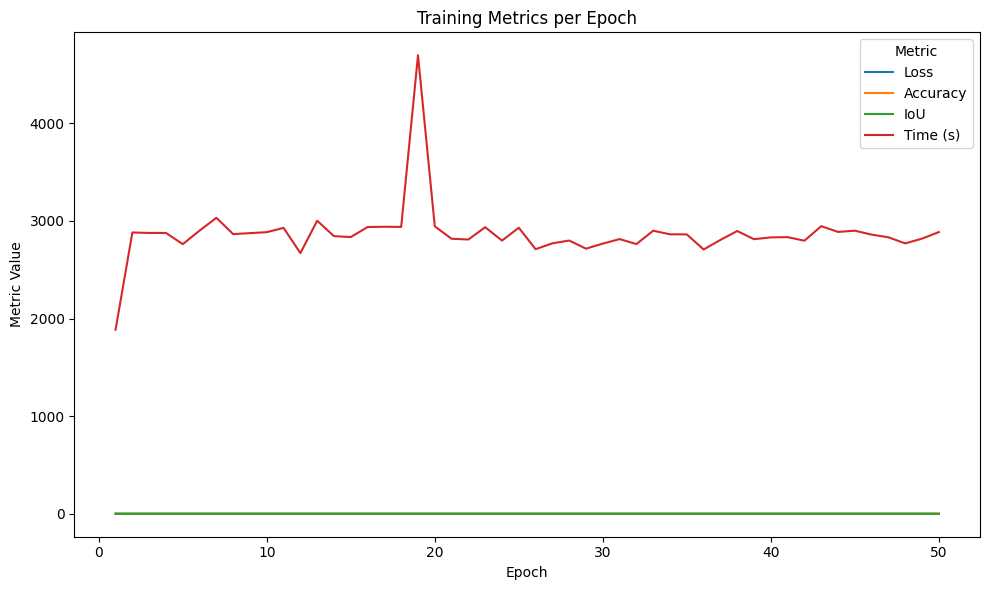

In [11]:
# Visualize with seaborn

# 1) Build DataFrame
df = pd.DataFrame({
    'epoch': range(1, len(loss_history) + 1),
    'Loss': loss_history,
    'Accuracy': acc_history,
    'IoU': iou_history,
    'Time (s)': time_history
})

# 2) Melt to long form for seaborn
df_long = df.melt(id_vars='epoch',
                  var_name='Metric',
                  value_name='Value')

# 3) Plot all metrics in one figure
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='epoch', y='Value', hue='Metric')  
plt.title('Training Metrics per Epoch')  
plt.xlabel('Epoch')  
plt.ylabel('Metric Value')  
plt.legend(title='Metric', loc='best')
plt.tight_layout()
plt.show()

In [14]:

checkpoint_path = "checkpoints/pointnet2_s3dis_transform_seg_x6_50_checkpoint_local.pth"

# Save model, optimizer state, and any other info needed
torch.save({
    'epoch': 50,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    #'loss': loss,
    #'test_accuracy': test_acc
}, checkpoint_path)

print("Checkpoint saved successfully!")

Checkpoint saved successfully!


In [13]:
df.to_csv("../docs/local_s3dis_train_metrics.csv", index=False)